In [1]:
from preproccessing import loadStooqData
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pyesg
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data = loadStooqData('cpimpl.m','1990-01-01','m')

In [7]:
def ornstein_uhlenbeck_params(series,period):
    lagged = series.shift(1).dropna()
    series = series.iloc[1:]
    lagged = sm.add_constant(lagged,prepend=False)
    model = sm.OLS(series['Zamkniecie'],lagged[['Zamkniecie','const']])
    res = model.fit()
    b = res.params['Zamkniecie']
    a = res.params['const']
    k = (1 -b)/(1/period)
    u = a/k
    resid = res.resid
    sig = np.sqrt(np.mean(resid**2))
    sig = np.round(sig,4)

    return (u,sig,k)


,Zamkniecie
count,216.000000
mean,0.001780
std,0.003331
min,-0.005013
25%,-0.000250
50%,0.001499
75%,0.003992
max,0.011929


<AxesSubplot:xlabel='Data', ylabel='Zamkniecie'>

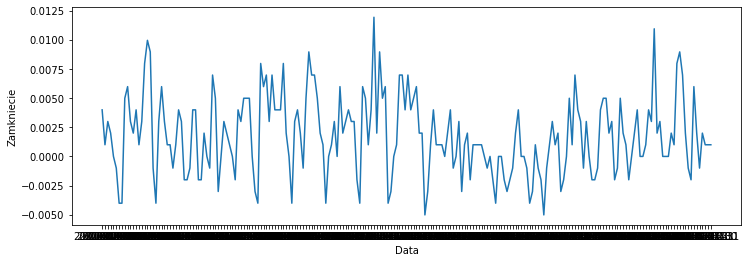

In [23]:
cpi = data['2003-01-01':'2020-12-31'] / 100
cpi = np.log(cpi+1)
cpi = cpi.reset_index()
display(cpi.describe())
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(data=cpi,x='Data',y='Zamkniecie', ax=ax)



<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

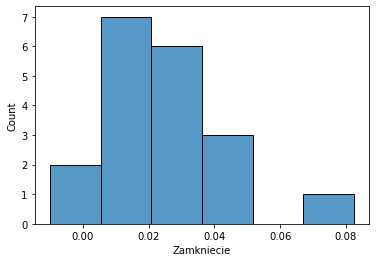

In [11]:
sns.histplot(data=cpi['Zamkniecie'])

<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

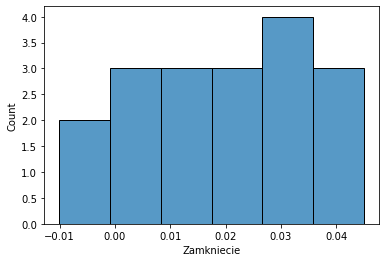

In [154]:
sns.histplot(data=cpi['Zamkniecie'])

In [155]:
u,sig,k = ornstein_uhlenbeck_params(cpi,1)
print(u)
print(sig)
print(k)

0.021349335221542323
0.0145
0.5814544599320829


In [156]:
#moje param mu - 2,5%, sig, 1,5%, k- 0.k
param_mu = u
param_sig = sig
param_k = k
simulator = pyesg.OrnsteinUhlenbeckProcess(mu=param_mu,sigma=param_sig,theta=param_k)

In [157]:
length = 30
h=1/12
scenarios = simulator.scenarios(0.1,h,1000,length*12)

In [158]:
perc = np.percentile(scenarios,[1,5,25,50,75,95,99],axis=0)

In [159]:
def fanchart(hist,percentiles):
    x = np.linspace(0,percentiles.shape[1],percentiles.shape[1])
    fig,ax = plt.subplots(figsize=(12,6))
    ax.fill_between(x=x,y1=percentiles[0],y2=percentiles[6], color='blue', alpha=0.1)
    ax.fill_between(x=x,y1=percentiles[1],y2=percentiles[5], color='blue', alpha=0.2)
    ax.fill_between(x=x,y1=percentiles[2],y2=percentiles[4], color='blue', alpha=0.3)
    ax.plot(percentiles[3],color='blue')

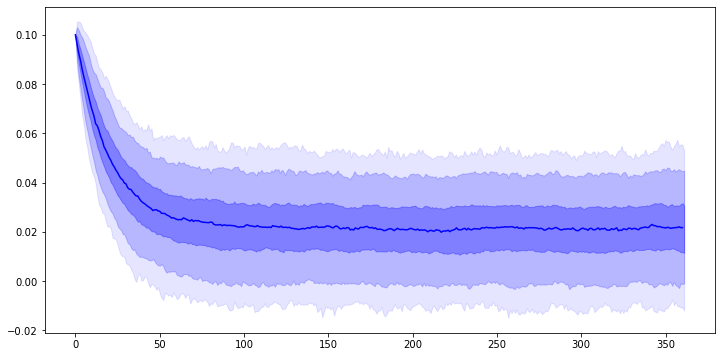

In [160]:
fanchart(cpi,perc)

In [161]:
def percentile_summary(perc,h):
    perc_dict = {'perc': ['1','5','25','50','75','95','99'],
                 '1': perc[:,1*h],
                 '2': perc[:,2*h],
                 '3': perc[:,3*h],
                 '5': perc[:,5*h],
                 '10': perc[:,10*h],
                 '20': perc[:,20*h],
                 '30': perc[:,30*h],
                 #'60': perc[:,60*h],
                 #'120': perc[:,120*h]
                 #'2': perc[:,24],
                 #'3': perc[:,36],
                 #'5': perc[:,60],
                 #'10': perc[:,120],
                 #'15': perc[:,180]
                 }
    
    perc_summary = pd.DataFrame(perc_dict)
    perc_summary.set_index('perc', inplace=True)
    return perc_summary
percentile_summary(perc,12)

,1,2,3,5,10,20,30
perc,,,,,,,
1,0.039487,0.016732,-0.000329,-0.007374,-0.009291,-0.008307,-0.012008
5,0.044978,0.024709,0.011106,0.002399,-0.001152,-0.000957,-0.001040
25,0.057329,0.036290,0.024956,0.015892,0.012677,0.012315,0.011432
50,0.063933,0.045097,0.034558,0.025045,0.022028,0.021047,0.021697
75,0.072865,0.054113,0.044303,0.034620,0.031381,0.030332,0.030682
95,0.084017,0.065693,0.056265,0.047196,0.045442,0.043779,0.044857
99,0.091593,0.073834,0.064466,0.057585,0.053567,0.053521,0.053014


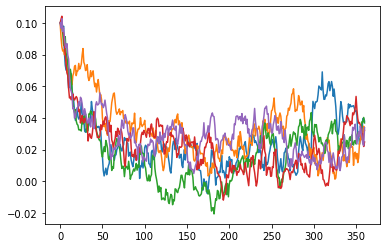

In [168]:
fig, ax = plt.subplots()
for i in np.random.randint(0,600,5):
    sns.lineplot(data=scenarios[i], ax=ax)



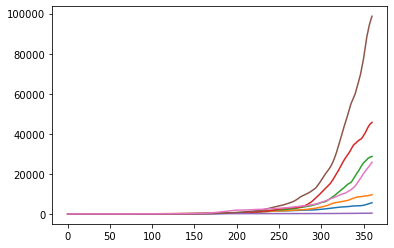

In [169]:
s_cum_prod = np.cumprod(np.exp(scenarios),1)
fig, ax = plt.subplots()
for i in np.random.randint(0,600,7):
    sns.lineplot(data=s_cum_prod[i], ax=ax)

In [164]:
year_cum = s_cum_prod[:,::12]

<AxesSubplot:xlabel='Zamkniecie', ylabel='Count'>

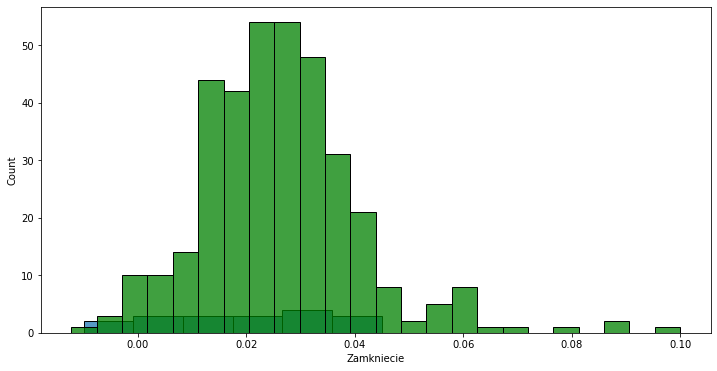

In [170]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(cpi['Zamkniecie'], ax=ax)
sns.histplot(scenarios[100],ax=ax,color='green')

In [172]:
means = scenarios.mean(1)

p = [1,5,25,50,75,95,99]
scenarios_perc = np.percentile(means,p)

for i in range(len(p)):
    print(str(np.round(p[i],4))+': '+str(np.round(scenarios_perc[i]*12,4)))


1: 0.1818
5: 0.2248
25: 0.2745
50: 0.3103
75: 0.3458
95: 0.3925
99: 0.418


In [167]:
#np.savetxt('inlfation_scenarios_23.09.23.csv',scenarios,comments='u=0.02,sig=0.014,k=0.64')

In [182]:
spread = 0.0125
edo = scenarios
edo [:,0:12] = 0.06
edo = np.lib.stride_tricks.sliding_window_view(edo,12,axis=1).mean(2) + spread
edo = edo/12

In [184]:
np.savetxt('edo_25.09.23_m.csv', np.round(edo,4),delimiter=', ', comments='testowa')

In [51]:
model = tsa.MarkovRegression(endog=cpi['Zamkniecie'],k_regimes=3, switching_variance=True)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:             Zamkniecie   No. Observations:                  216
Model:               MarkovRegression   Log Likelihood                 951.740
Date:                Mon, 13 Nov 2023   AIC                          -1879.480
Time:                        22:15:19   BIC                          -1838.977
Sample:                             0   HQIC                         -1863.117
                                - 216                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -3.384      0.001      -0.003      -0.001
sigma2      2.562e-06   8.99e-07      2.851      0.004    8.01e-07    4.32e-06
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.892      0.000       0.001       0.002
sigma2      2.441e-06   7.82e-07      3.121      0.002    9.08e-07    3.97e-06
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.001     10.002      0.000       0.004       0.006
sigma2      5.927e-06    1.3e-06      4.557      0.000    3.38e-06    8.48e-06
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5466      0.101      5.416      0.000       0.349       0.744
p[1->0]        0.2588      0.112      2.313      0.021       0.040       0.478
p[2->0]        0.0575      0.044      1.316      0.188      -0.028       0.143
p[0->1]        0.2283      0.113      2.024      0.043       0.007       0.449
p[1->1]        0.6737      0.101      6.679      0.000       0.476       0.871
p[2->1]        0.2186      0.080      2.749      0.006       0.063       0.374
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [52]:
result.params

p[0->0]      0.546572
p[1->0]      0.258776
p[2->0]      0.057458
p[0->1]      0.228252
p[1->1]      0.673680
p[2->1]      0.218571
const[0]    -0.001876
const[1]     0.001512
const[2]     0.005194
sigma2[0]    0.000003
sigma2[1]    0.000002
sigma2[2]    0.000006
dtype: float64

In [50]:
result.params['const[1]'] * 12

0.06114471033834032

In [48]:
np.round(result.params['sigma2[1]'] * 12,4)

0.0001

In [38]:
np.sqrt(12)

3.4641016151377544